In [ ]:
import torch
import torch.nn as nn
import gym
import time
import numpy as np
import matplotlib.pyplot as plt

In [87]:
from collections import defaultdict

In [96]:
def discretize_state(state, levels=10):
    if isinstance(state, (np.ndarray, list)):
        # Если `state` — массив, дискретизируем каждый элемент
        discrete_state = np.round(np.array(state) * levels) / levels
        return tuple(discrete_state)  # Преобразуем в кортеж для использования в Q-таблице
    else:
        # Если `state` — одиночное число, просто дискретизируем его
        return round(state * levels) / levels

### $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [4]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    prob = np.ones(action_n) * epsilon / action_n
    argmax_action = np.argmax(q_values)
    prob[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p=prob)
    return action

### Monte-Carlo Algorithm

Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$


In [128]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    if np.random.rand() < epsilon:
        return np.random.choice(action_n)  # Случайное действие
    else:
        return np.argmax(q_values)  # Наилучшее действие

In [154]:
def MonteCarlo(state_n, action_n, env, episode_n, trajectory_len=500, gamma=0.99):
    q_values = defaultdict(lambda: np.zeros(action_n))
    #q_values = defaultdict(lambda: np.ones(action_n) * 10)  # Начальные значения Q-значений больше 0

    counters = defaultdict(lambda: np.zeros(action_n))

    levels = 10

    total_rewards = []
    for episode in range(episode_n):
        print(f'Episode = {episode}')
        epsilon = 1 - episode / episode_n
        #epsilon = max(0.01, 1 - episode / (episode_n * 3))  # Более медленное уменьшение ε
        #epsilon = max(0.1, 1 - episode / (episode_n * 1.5))  # Начальное значение ε ограничено минимумом в 0.1
        #gamma = np.random.uniform(0.9, 0.99)

        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()
        state = tuple([discretize_state(st, levels=levels) for st in state])

        for t in range(trajectory_len):
            action = get_epsilon_greedy_action(q_values[state], epsilon, action_n)
            next_state, reward, done, _ = env.step(action)
            next_state = tuple([discretize_state(st, levels=levels) for st in next_state])

            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)

            state = next_state
            
            if done:
                break

        total_rewards.append(np.sum(trajectory['rewards']))
        
        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            counters[state][action] += 1
            q_values[state][action] += (returns[t] - q_values[state][action]) / counters[state][action]

        print(total_rewards[-1])

    return total_rewards

In [155]:
MonteCarlo_total_rewards = MonteCarlo(state_n=state_n, action_n=action_n, env=env, episode_n=20000, trajectory_len=500, gamma=0.99)

Episode = 0
14.0
Episode = 1
13.0
Episode = 2
18.0
Episode = 3
12.0
Episode = 4
21.0
Episode = 5
16.0
Episode = 6
28.0
Episode = 7
18.0
Episode = 8
13.0
Episode = 9
15.0
Episode = 10
8.0
Episode = 11
32.0
Episode = 12
16.0
Episode = 13
68.0
Episode = 14
10.0
Episode = 15
27.0
Episode = 16
22.0
Episode = 17
18.0
Episode = 18
27.0
Episode = 19
16.0
Episode = 20
16.0
Episode = 21
31.0
Episode = 22
17.0
Episode = 23
38.0
Episode = 24
39.0
Episode = 25
28.0
Episode = 26
30.0
Episode = 27
15.0
Episode = 28
12.0
Episode = 29
56.0
Episode = 30
40.0
Episode = 31
14.0
Episode = 32
56.0
Episode = 33
20.0
Episode = 34
29.0
Episode = 35
20.0
Episode = 36
14.0
Episode = 37
22.0
Episode = 38
16.0
Episode = 39
14.0
Episode = 40
13.0
Episode = 41
41.0
Episode = 42
15.0
Episode = 43
62.0
Episode = 44
27.0
Episode = 45
15.0
Episode = 46
27.0
Episode = 47
12.0
Episode = 48
16.0
Episode = 49
34.0
Episode = 50
12.0
Episode = 51
31.0
Episode = 52
20.0
Episode = 53
24.0
Episode = 54
15.0
Episode = 55
23.0
Epi

### Solving Taxi-v2 by means of MonteCarlo

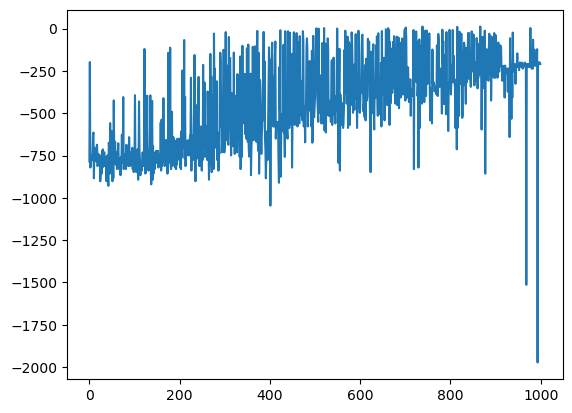

In [6]:
total_rewards = MonteCarlo(env, episode_n=1000, trajectory_len=1000, gamma=0.99)

plt.plot(total_rewards)
plt.show()

### SARSA Algorithm 
Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$


In [178]:
def SARSA(action_n, state_n, env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5, levels=10):
    q_values = defaultdict(lambda: np.zeros(action_n))

    total_rewards = []
    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n

        total_reward = 0

        state = env.reset()
        state = tuple([discretize_state(st, levels=levels) for st in state])
        action = get_epsilon_greedy_action(q_values[state], epsilon, action_n)
        for t in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_state = tuple([discretize_state(st, levels=levels) for st in next_state])
            
            next_action = get_epsilon_greedy_action(q_values[next_state], epsilon, action_n)

            q_values[state][action] += alpha * (reward + gamma * q_values[next_state][next_action] - q_values[state][action])

            total_reward += reward

            state = next_state
            action = next_action

            if done:
                break

        total_rewards.append(total_reward)
    
    return total_rewards

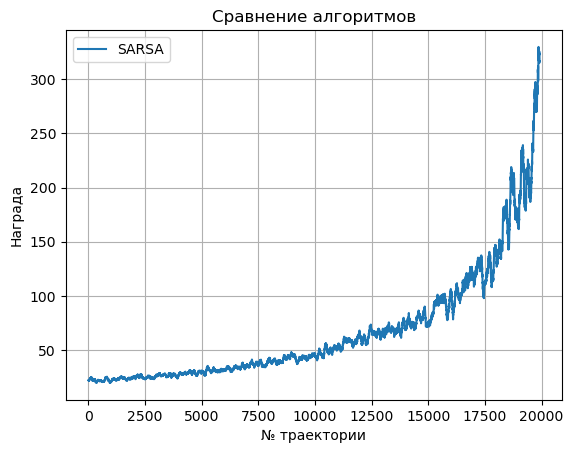

In [185]:
total_rewards = SARSA(state_n=state_n, action_n=action_n, env=env, episode_n=20000, trajectory_len=500, gamma=0.999, alpha=0.3)

window = 100
plot_results(SARSA_total_rewards=total_rewards)

### Q-Learning Algorithm

Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [173]:
def QLearning(action_n, state_n, env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5, levels=10):
    q_values = defaultdict(lambda: np.zeros(action_n))

    total_rewards = []

    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n

        total_reward = 0

        state = env.reset()
        state = tuple([discretize_state(st, levels=levels) for st in state])
        action = get_epsilon_greedy_action(q_values[state], epsilon, action_n)
        
        for t in range(t_max):
            next_state, reward, done, _ = env.step(action)
            next_state = tuple([discretize_state(st, levels=levels) for st in next_state])
            next_action = get_epsilon_greedy_action(q_values[next_state], epsilon, action_n)

            q_values[state][action] += alpha * (reward + gamma * np.max(q_values[next_state]) - q_values[state][action])

            total_reward += reward

            state = next_state
            action = next_action

            if done:
                break
        #print(total_reward)
        total_rewards.append(total_reward)
    
    return total_rewards

In [174]:
def moving_average(data, window):
    return np.convolve(data, np.ones(window) / window, mode='valid')

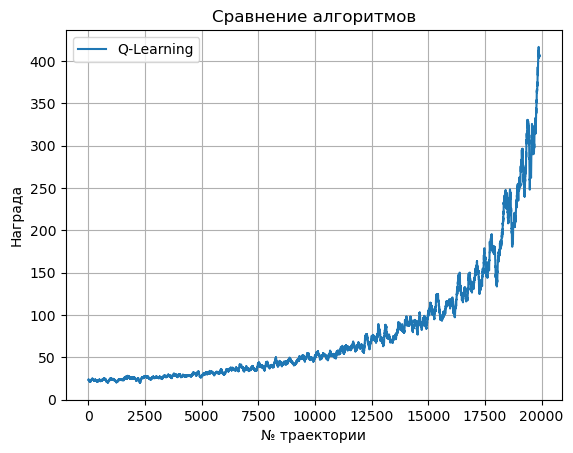

In [175]:
total_rewards = QLearning(env=env, action_n=action_n, state_n=state_n, episode_n=20000, noisy_episode_n=400, t_max=500, gamma=0.999, alpha=0.5, levels=10)

window = 100
plot_results(QLearning_total_rewards=total_rewards)

# Cross-Enthropy Method

In [33]:
class CrossEntropyAgent():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n

        self.model = np.ones((self.state_n, self.action_n)) / self.action_n

    def get_action(self, state):
        probs = self.model[state]
        normalized_probs = probs / np.sum(probs)  # нормализация вероятностей
        action = np.random.choice(np.arange(self.action_n), p=normalized_probs)
        return int(action)

    def fit(self, elite_trajectories, smoothing, coef_lambda):
        new_model = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1

        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                if smoothing == 'Policy':
                    if(0 < coef_lambda <= 1):
                        new_model[state] = coef_lambda * new_model[state] + (1 - coef_lambda) * self.model[state].copy()
                    else:
                        print('Выбран неправильный коэффициент лямбда для сглаживания политики')
                        return
            else:
                new_model[state] = self.model[state].copy()
        self.model = new_model
        return None

def get_state(obs):
    return int(np.sqrt(state_n) * obs[0] + obs[1])

def get_trajectory(env, agent, trajectory_len):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    obs = env.reset()
    state = obs

    for _ in range(trajectory_len):
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        obs, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
        
        state = obs

        if done:
            break
    
    return trajectory

def fit_agent(q_param, iteration_n, trajectory_n, smoothing, coef_lambda):
    agent = CrossEntropyAgent(state_n, action_n)
    mean_total_rewards = []

    for iteration in range(iteration_n):

        #policy evaluation
        trajectories = [get_trajectory(env, agent, 1000) for _ in range(trajectory_n)]
        total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
        
        #mean_total_rewards.append(np.mean(total_rewards))
        mean_total_rewards.extend([np.mean(total_rewards)] * trajectory_n)
        #print(f'Iteration {iteration}, mean_total_reward = {mean_total_rewards[-1]}')

        new_q_param = q_param

        #policy improvement
        quantile = np.quantile(total_rewards, new_q_param)
        elite_trajectories = []
        for trajectory, total_reward in zip(trajectories, total_rewards):
            if total_reward > quantile:
                elite_trajectories.append(trajectory)

        agent.fit(elite_trajectories, smoothing, coef_lambda)

    trajectory = get_trajectory(env, agent, trajectory_len=100)

    return mean_total_rewards

# Deep Cross-Enthropy

In [198]:
class DCEM(nn.Module):
    def __init__(self, state_dim, action_n, epsilon=0, epsilon_decrease=1e-3, epsilon_min=1e-2, hidden_size=128, lr=1e-2):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.network = nn.Sequential(nn.Linear(self.state_dim, hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(hidden_size, self.action_n)
                                    )
        self.softmax = nn.Softmax()
        self.optimazer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.CrossEntropyLoss()
        self.epsilon = epsilon
        self.epsilon_descrease = epsilon_decrease
        self.epsilon_min = epsilon_min

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        #probs = self.softmax(logits)
        probs = (1 - self.epsilon) * self.softmax(logits) + self.epsilon / self.action_n
        action = np.random.choice(self.action_n, p=probs.data.numpy())
        return action

    def fit(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)

        # Преобразуем списки в numpy.ndarray для повышения эффективности
        elite_states = np.array(elite_states)
        elite_actions = np.array(elite_actions)

        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        pred_actions = self.forward(elite_states)

        loss = self.loss(pred_actions, elite_actions)
        loss.backward()
        self.optimazer.step()
        self.optimazer.zero_grad()

        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_descrease)

def get_trajectory(env, agent, max_len=1000, levels=10):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    state = env.reset()
    
    for _ in range(max_len):
        #state = [discretize_state(st, levels=levels) for st in state]
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)

        if done:
            break

    return trajectory

def DCEM_fit_agent(env, state_dim, action_n, iteration_n, epsilon, hidden_size, lr, trajectory_n, trajectory_len, q):
    agent = DCEM(state_dim, action_n, epsilon_decrease=1/iteration_n, epsilon=epsilon, hidden_size=hidden_size, lr=lr)
    mean_total_rewards = []
    for iteration in range(iteration_n):
        #policy evaluation
        trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
        total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
        #print('iteration:', iteration, 'mean total reward:', np.mean(total_rewards))

        #mean_total_rewards.append(np.mean(total_rewards))
        mean_total_rewards.extend([np.mean(total_rewards)] * trajectory_n)

        #policy improvement
        quantile = np.quantile(total_rewards, q)
        elite_trajectories = []
        for trajectory in trajectories:
            total_reward = np.sum(trajectory['rewards'])
            if total_reward > quantile:
                elite_trajectories.append(trajectory)

        if len(elite_trajectories) > 0:
            agent.fit(elite_trajectories)

    trajectory = get_trajectory(env, agent, max_len=trajectory_len)
    return mean_total_rewards

# Compare all methods

In [80]:
env = gym.make("Taxi-v3")
state_n, action_n = env.observation_space.n, env.action_space.n

In [145]:
env = gym.make('CartPole-v1')
state_n= 4
action_n = 2

In [200]:
window = 100

def plot_results(QLearning_total_rewards = None, SARSA_total_rewards = None, MonteCarlo_total_rewards = None, CrossEntropy_total_rewards = None):

    if QLearning_total_rewards is not None:
        QLearning_trajectories = np.arange(1, len(QLearning_total_rewards) + 1)
        plt.plot(QLearning_trajectories[:len(moving_average(QLearning_total_rewards, window))], moving_average(QLearning_total_rewards, window), label='Q-Learning')

    if SARSA_total_rewards is not None:
        SARSA_trajectories = np.arange(1, len(SARSA_total_rewards) + 1)
        plt.plot(SARSA_trajectories[:len(moving_average(SARSA_total_rewards, window))], moving_average(SARSA_total_rewards, window), label='SARSA')

    if MonteCarlo_total_rewards is not None:
        MonteCarlo_trajectories = np.arange(1, len(MonteCarlo_total_rewards) + 1)
        plt.plot(MonteCarlo_trajectories[:len(moving_average(MonteCarlo_total_rewards, window))], moving_average(MonteCarlo_total_rewards, window), label='MonteCarlo')

    if CrossEntropy_total_rewards is not None:
        CrossEntropy_trajectories = np.arange(1, len(CrossEntropy_total_rewards) + 1)
        plt.plot(CrossEntropy_trajectories[:len(moving_average(CrossEntropy_total_rewards, window))], moving_average(CrossEntropy_total_rewards, window), label='CrossEnthropy')

    plt.legend()
    plt.grid()
    plt.title('Сравнение алгоритмов')
    plt.xlabel('№ траектории')
    plt.ylabel('Награда')
    plt.show()

In [ ]:
CrossEntropy_total_rewards = fit_agent(q_param=0.4, iteration_n=16, trajectory_n=400, smoothing='Policy', coef_lambda=0.95)

In [205]:
QLearning_total_rewards = QLearning(env=env, action_n=action_n, state_n=state_n, episode_n=20000, noisy_episode_n=400, t_max=500, gamma=0.999, alpha=0.5, levels=10)

In [206]:
SARSA_total_rewards = SARSA(state_n=state_n, action_n=action_n, env=env, episode_n=20000, trajectory_len=500, gamma=0.999, alpha=0.3)

In [212]:
MonteCarlo_total_rewards = MonteCarlo(state_n=state_n, action_n=action_n, env=env, episode_n=20000, trajectory_len=500, gamma=0.99)

Episode = 0
11.0
Episode = 1
18.0
Episode = 2
37.0
Episode = 3
18.0
Episode = 4
14.0
Episode = 5
22.0
Episode = 6
12.0
Episode = 7
46.0
Episode = 8
13.0
Episode = 9
13.0
Episode = 10
10.0
Episode = 11
12.0
Episode = 12
46.0
Episode = 13
31.0
Episode = 14
20.0
Episode = 15
30.0
Episode = 16
15.0
Episode = 17
14.0
Episode = 18
33.0
Episode = 19
27.0
Episode = 20
20.0
Episode = 21
13.0
Episode = 22
22.0
Episode = 23
53.0
Episode = 24
15.0
Episode = 25
23.0
Episode = 26
11.0
Episode = 27
14.0
Episode = 28
10.0
Episode = 29
25.0
Episode = 30
19.0
Episode = 31
48.0
Episode = 32
14.0
Episode = 33
25.0
Episode = 34
26.0
Episode = 35
11.0
Episode = 36
33.0
Episode = 37
10.0
Episode = 38
12.0
Episode = 39
17.0
Episode = 40
20.0
Episode = 41
12.0
Episode = 42
28.0
Episode = 43
20.0
Episode = 44
13.0
Episode = 45
13.0
Episode = 46
14.0
Episode = 47
27.0
Episode = 48
12.0
Episode = 49
29.0
Episode = 50
13.0
Episode = 51
13.0
Episode = 52
14.0
Episode = 53
11.0
Episode = 54
43.0
Episode = 55
14.0
Ep

In [210]:
DeepCrossEntropy_total_rewards = DCEM_fit_agent(env=env, state_dim=state_n, action_n=action_n, iteration_n=100, epsilon=0.3, 
                                                hidden_size=128, lr=1e-2, trajectory_n=50, trajectory_len=300, q=0.8)

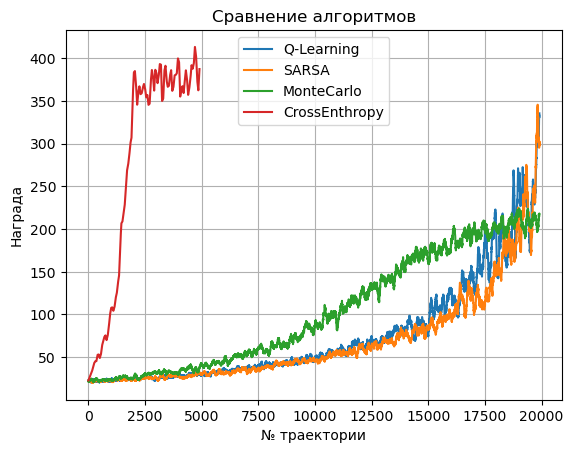

In [213]:
plot_results(QLearning_total_rewards, SARSA_total_rewards, MonteCarlo_total_rewards, DeepCrossEntropy_total_rewards)